# Interpolacja i transformacje
Opracowanie: A.Florkowska

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from IPython.display import Image
from skimage import color, io

In [2]:
normalize = lambda image: (image - np.min(image)) / (np.max(image) - np.min(image)) 
image = io.imread(".././images/example1.png")
image = image[:,:,0:3]
image = color.rgb2gray(image)
image = normalize(image)

# Interpolacja
Interpolacja w przetwarzaniu obrazów jest techniką używaną do zmiany rozmiaru obrazów, czyli do powiększania lub pomniejszania, oraz do poprawiania geometrii obrazu w procesach takich jak rotacja czy skos. Umożliwia znalezienie wartości obrazu w niezdefiniowanym punkcie na podstawie sąsiadujących pikseli w taki sposób, aby był on jak najlepiej dopasowany optycznie do transformowanego obrazu (= zapewnienie płynnego przejścia między pikselami i zachowanie jakości obrazu po transformacji). Metoda ta znajduje swoje zastosowanie w wizji komputerowej, edycji obrazów i grafice komputerowej. 

Istnieje kilka głównych metod interpolacji, z których każda oferuje różne kompromisy między jakością a złożonością obliczeniową.

- Interpolacja najbliższego sąsiada
  * To najprostsza i najszybsza metoda interpolacji
  * Polega na przydzieleniu każdemu nowemu pikselowi wartości najbliższego piksela z obrazu źródłowego.
  * Może prowadzić do efektu schodkowania (aliasingu), zwłaszcza przy znaczącym powiększeniu obrazu.
- Interpolacja liniowa (bilinearna)
  * Bardziej zaawansowana metoda
  * Bierze pod uwagę wartości czterech najbliższych pikseli z obrazu źródłowego podczas obliczania wartości nowego piksela. Dzieje się to poprzez wykonanie liniowej interpolacji najpierw w jednym kierunku, a następnie w drugim - stąd nazwa.
  * Uzyskany obraz jest gładszy, w porównaniu z metodą najbliższego sąsiada
- Interpolacja dwusześcienna (bicubic)
  * Jeszcze bardziej zaawansowana technika
  * W obliczeniach uwzględnia 16 najbliższych pikseli (4x4 otoczenie piksela docelowego).
  * Używa wielomianów trzeciego stopnia do wygładzania przejść między pikselami, co prowadzi do jeszcze większej płynności obrazu. Jest to często używana metoda w profesjonalnych aplikacjach do edycji obrazów ze względu na dobrą równowagę między jakością a czasem przetwarzania.
 
Wybór metody interpolacji jest często podyktowany różnymi warunkami: czasem przetwarzania, oczekiwaną jakością obrazu wyjściowego czy typem danych wejściowych. Przykładowo, podczas analizy obrazów binarnych (wartości 0 lub 1) nie można użyć interpolacji liniowej (wprowadziłaby nową uśrednioną wartość, inną niż 0 lub 1), zalecana jest wtedy metoda najbliższego sąsiada.

# Interpolacja metodą najbliższego sąsiada 2D - algorytm

1. Zaokrąglenie wspołrzędnych do najbliższych mniejszych liczb całkowitych, aby znaleźć najbliższe punkty w macierzy.
2. Sprawdzenie, czy wyznaczone indeksy nie wychodzą poza granice macierzy danych.
3. Obliczenie współczynników wagowych.
4. Interpolacja na podstawie obliczonych współczynników i wartości pikseli najbliższych punktów danych.

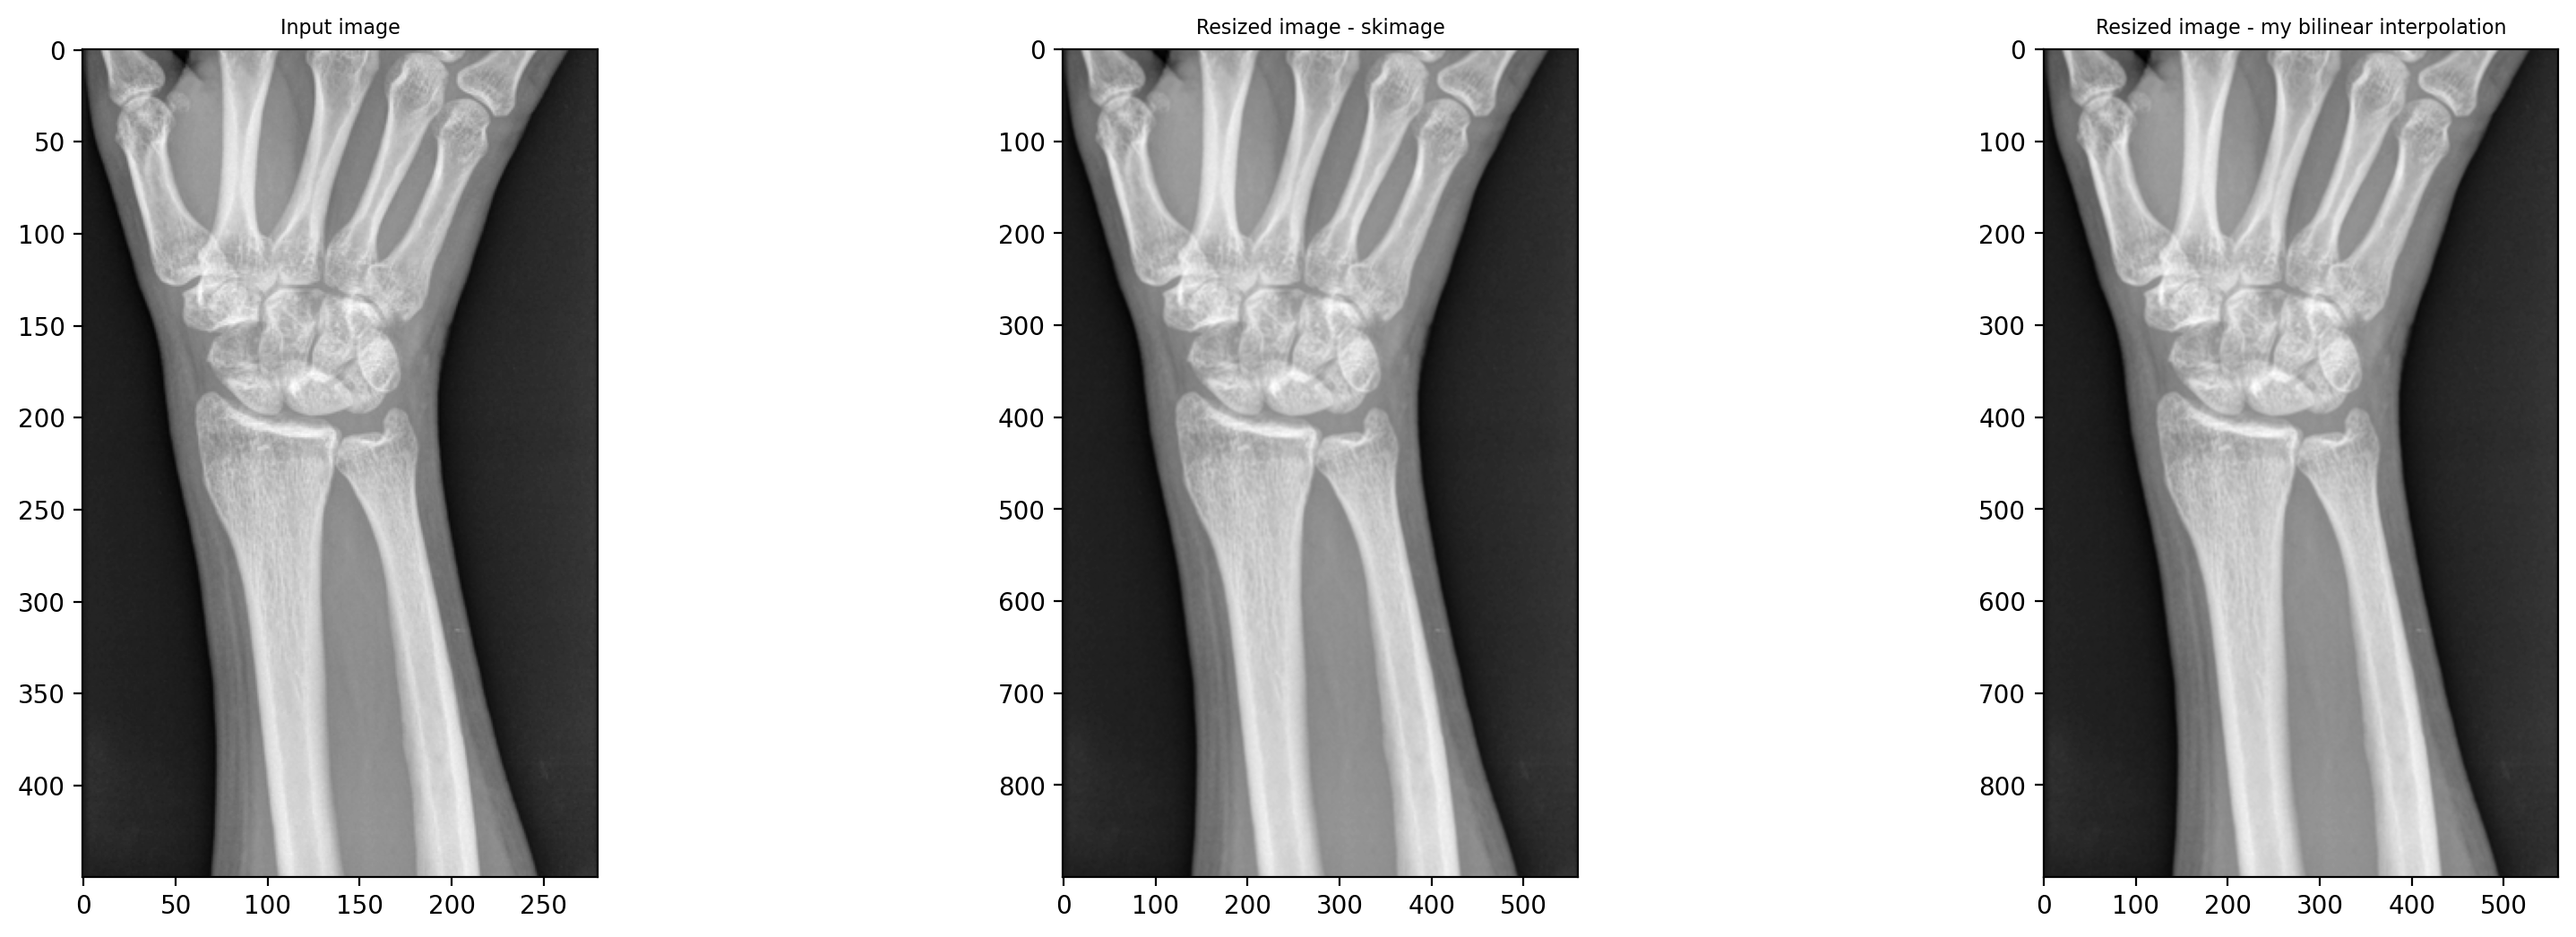

In [3]:
def interpolateNN_2D(image, output_size):
    # Assuming image is a 2D array (grayscale image) and output_size is a tuple
    height = image.shape[0]
    width = image.shape[1]
    scale_x = (width)/(output_size[1])
    scale_y = (height)/(output_size[0])
    output_image = np.zeros((output_size[0], output_size[1]))
    
    for i in range(output_size[0]):
        for j in range(output_size[1]):
            # Calculating indeces - using this formula ensures that the pixel centers of the output image are correctly mapped to corresponding points in the input image, 
            # considering the scale factor. 
            ###    Factor ' + 0.5' shifts the coordinate system so that i/j indexes the center of each pixel in the output image, rather than the top-left corner.
            ###    Factor '* scale' converts the position from output image space (where coordinates are based on the new dimensions) to input image space (where coordinates are based on the original dimensions).
            ###    Factor '- 0.5' shifts the coordinate back so that it aligns correctly within the original image’s coordinate system, essentially moving from a pixel center alignment to the appropriate coordinate in the input image for interpolation. It compensates for the initial centering shift made in the output image coordinates.
            x = (j + 0.5) * (scale_x) - 0.5
            y = (i + 0.5) * (scale_y) - 0.5
            x_left = np.int64(x)
            x_right = np.int64(x) + 1
            y_up = np.int64(y)
            y_down = np.int64(y) + 1
            # Clipping indices to ensure they fall within the image bounds
            y_up, y_down = np.clip([y_up, y_down], 0, image.shape[0] - 1)
            x_left, x_right = np.clip([x_left, x_right], 0, image.shape[1] - 1)
            # Extracting values for interpolation
            a = image[y_up, x_left]
            b = image[y_up, x_right]
            c = image[y_down, x_left]
            d = image[y_down, x_right]
            # Calculating weights
            x_diff = x - x_left
            y_diff = y - y_up
            # Weighted sum
            interpolated_point = a * (1 - x_diff) * (1 - y_diff) + b * x_diff * (1 - y_diff) + c * (1 - x_diff) * y_diff + d * x_diff * y_diff
            # Assigning the interpolated value to new_img
            output_image[i,j] = interpolated_point 
            
    return output_image

# Data interpolation - resizing image
new_height = 2 * image.shape[0]
new_width = 2 * image.shape[1]
# Mode equals 'constant' ensures nearest-neighbour interpolation while resizing the image
resized_image = resize(image, (new_height, new_width), mode='constant', anti_aliasing=False)
my_resized_image = interpolateNN_2D(image, (new_height, new_width))

plt.figure(figsize=(20, 6), dpi=200)
plt.subplot(1, 3, 1)
plt.imshow(image, cmap="gray")
plt.title('Input image', fontsize=8)
plt.subplot(1, 3, 2)
plt.imshow(resized_image, cmap="gray")
plt.title('Resized image - skimage', fontsize=8)
plt.subplot(1, 3, 3)
plt.imshow(my_resized_image, cmap="gray")
plt.title('Resized image - my bilinear interpolation', fontsize=8)
plt.show()

# Transformacja 
To działanie mające na celu manipulację obiektami lub obrazami poprzez zmianę ich położenia, rozmiaru, kształtu lub orientacji w przestrzeni. Obejmuje poniższe działania:
* Translacja: Przesuwanie obiektu lub obrazu w określonym kierunku.
* Skalowanie: Zmiana rozmiaru obiektu lub obrazu poprzez zmianę jego wymiarów.
* Obrót: Obracanie obiektu lub obrazu wokół określonego punktu lub osi.
* Przekształcenie afiniczne: Złożona transformacja obejmująca translację, skalowanie, obrót i/lub ścinanie.
* Ścinanie: Zniekształcanie obiektu lub obrazu poprzez zastosowanie przekształcenia perspektywicznego.

Wyróżnia się również dwa rodzaje transformacji: 
- Transformacja sztywna (rigid transformation)
  * Zachowuje odległości i kąty między punktami w przestrzeni.
  * Oznacza to, że obiekt poddany transformacji sztywnej zostaje przesunięty, obrócony lub obrotno-przesunięty (czyli przesunięty i obrócony jednocześnie), ale jego kształt i rozmiar nie ulegają zmianie.
  * Transformacja sztywna jest definiowana przez translację (przesunięcie) i/lub obrót obiektu. 
- Transformacja afiniczna (affine transformation)
  * Zachowuje linie prostą, ale niekoniecznie odległości i kąty.
  * Oznacza to, że obiekt poddany transformacji afinicznej może zostać przesunięty, obrócony, skalowany i ścinany (przekształcony perspektywicznie).
  * W przeciwieństwie do transformacji sztywnej, transformacja afiniczna może również zmieniać kształt i rozmiar obiektu. 

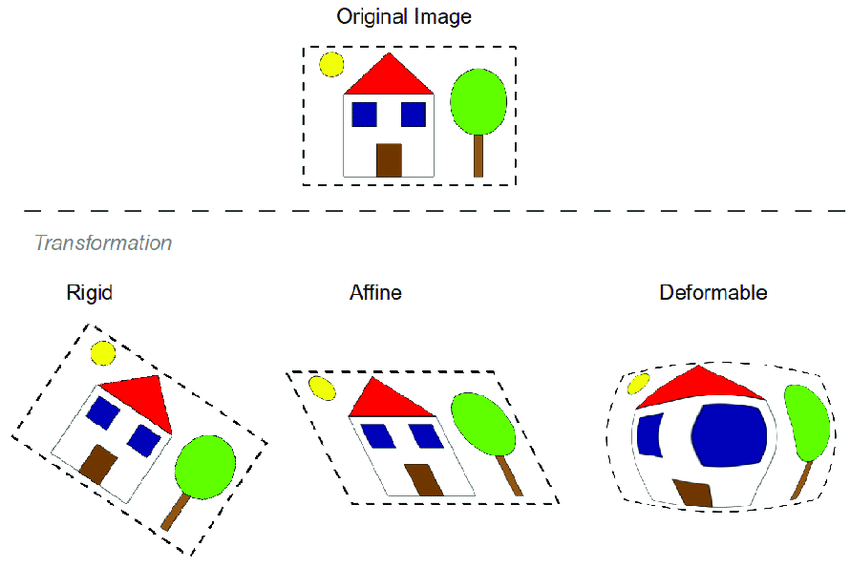

In [4]:
Image(filename=".././images/8_1.png", width=600)
# Source: https://www.researchgate.net/figure/Three-types-of-transformations-visualized-in-2D-rigid-affine-and-deformable-Rigid_fig8_279825250 

# Macierze transformacji
Transformacje są wykonywane za pomocą macierzy transformacji, które opisują zmianę współrzędnych obiektów w przestrzeni. Każda operacja transformacji ma swoją macierz odpowiadającą za to przekształcenie. Na przykład, macierz translacji przesuwa obiekt o określony wektor, macierz skalowania zmienia rozmiar obiektu przez mnożenie współrzędnych przez odpowiednie skale, a macierz obrotu obraca obiekt o określony kąt (podany w radianach).

Macierze mają wymiar o jeden większy niż przestrzeń na której operują, czyli przekształcenie w 2D to macierz 3x3, a w 3D to 4x4.

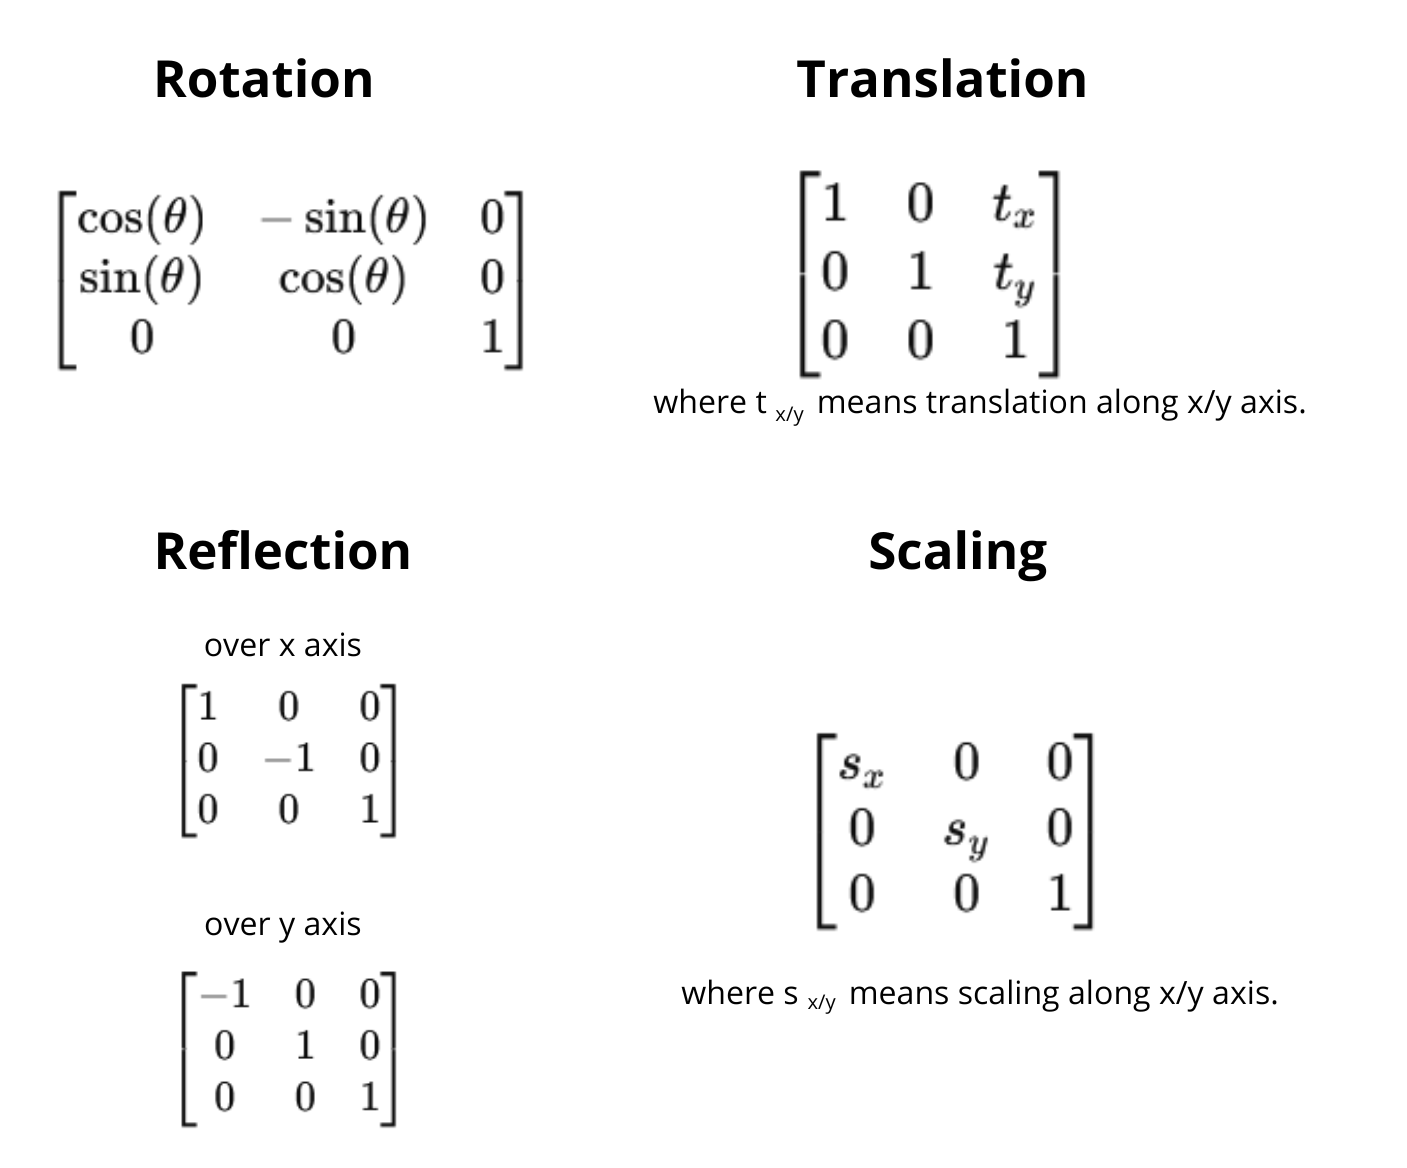

In [5]:
Image(filename=".././images/8_2.png", width=500)

In [6]:
def generate_rigid_matrix(xtranslation, ytranslation, rot_angle):
  rot = np.deg2rad(rot_angle)
  rigid_matrix = np.array([
      [np.cos(rot), -np.sin(rot), xtranslation],
      [np.sin(rot), np.cos(rot), ytranslation],
      [0, 0, 1]                     
      ])
  return rigid_matrix

# Example of rigid matrix enabling translation about 100px along x-axis and -40px along y-axis, as well as rotation about 45 degree.
rigid_matrix=generate_rigid_matrix(100,-40,45)
print(rigid_matrix)

[[  0.70710678  -0.70710678 100.        ]
 [  0.70710678   0.70710678 -40.        ]
 [  0.           0.           1.        ]]


# Przekształcenia - algebra
Macierz transformacji to specjalny rodzaj macierzy, który służy do przekształcania wektorów. W praktyce, mnożąc macierz transformacji przez wektor, otrzymujemy nowy wektor, który jest wynikiem zastosowania danej transformacji. Innymi słowy, to działanie można przedstawić jako zmianę współrzędnych punktów, które wektor reprezentuje.

Chcąc cofnąć wykonaną operację, wystarczy pomnożyć wynikowy wektor przez macierz odwrotną macierzy transformacji wykonanej operacji. To podejście jest bardzo przydatne np. w celu przywrócenia obiektu do jego pierwotnego położenia po zastosowaniu pewnych transformacji geometrycznych.

# Obrót względem środka - algorytm
1. Obliczenie współrzędnych środka obrazu.
2. Stworzenie macierzy transformacji umożliwiającą translacje z lewego, górnego narożnika (punkt 0,0) do środka obrazu.
3. Obliczenie macierzy transformacji wokół środka jako mnożenie: macierzy translacji do środka, macierzy transformacji (rotacja + translacja) i macierzy odwrotnej macierzy translacji do środka. 

In [14]:
def center_matrix(transform, shape):
  x_origin = (shape[1] - 1) / 2
  y_origin = (shape[0] - 1) / 2
  a = np.array([
    [1, 0, x_origin],
    [0, 1, y_origin],
    [0, 0, 1],
  ])
  centered_matrix = a @ transform @ np.linalg.inv(a)
  return centered_matrix

print("Transformation matrix: rotation and translation\n")
print(rigid_matrix)
print("\nCentered transformation matrix: rotation and translation\n")
print(center_matrix(rigid_matrix, (100, 100)))

Transformation matrix: rotation and translation

[[  0.70710678  -0.70710678 100.        ]
 [  0.70710678   0.70710678 -40.        ]
 [  0.           0.           1.        ]]

Centered transformation matrix: rotation and translation

[[  0.70710678  -0.70710678 149.5       ]
 [  0.70710678   0.70710678 -60.50357134]
 [  0.           0.           1.        ]]


In [20]:
#wlasna implementacja transformacji sztywnej - porownanie

In [18]:
def interpolateNN_2D(image, output_size, transform=None):
    # Assuming image is a 2D array (grayscale image), output_size is a tuple, and transform means transformation matrix
    height = image.shape[0]
    width = image.shape[1]
    if transform is not None:
        output_image = np.zeros_like(image)
    else: 
        output_image = np.zeros((output_size[0], output_size[1]))
    
    for i in range(output_image.shape[0]):
        for j in range(output_image.shape[1]):
            if transform is not None:
                # With transformation matrix
                coord = np.dot(transform, np.array([j, i, 1]))
                x = coord[0]
                y = coord[1]
            else:
                # Resizing without transformation
                scale_x = width / output_size[1]
                scale_y = height / output_size[0]
                x = (j + 0.5) * scale_x - 0.5
                y = (i + 0.5) * scale_y - 0.5
            
            # Calculating indeces
            x_left = int64(x)
            x_right = x_left + 1
            y_up = int64(y)
            y_down = y_up + 1
            # Clipping indices to ensure they fall within the image bounds
            x_left, x_right = np.clip([x_left, x_right], 0, width - 1)
            y_up, y_down = np.clip([y_up, y_down], 0, height - 1)
            # Extracting values for interpolation
            a = image[y_up, x_left]
            b = image[y_up, x_right]
            c = image[y_down, x_left]
            d = image[y_down, x_right]
            # Calculating weights
            x_diff = x - x_left
            y_diff = y - y_up
            # Weighted sum
            interpolated_point = (a * (1 - x_diff) * (1 - y_diff) + b * x_diff * (1 - y_diff) + c * (1 - x_diff) * y_diff + d * x_diff * y_diff)
            # Assigning the interpolated value to output image
            output_image[i, j] = interpolated_point

    return output_image

# Pole przemieszczeń obrazu
Pole przemieszczeń obrazu opisuje przesunięcia punktów obrazu względem ich położenia referencyjnego. Jest to wektorowe pole, które określa, o ile każdy piksel obrazu został przesunięty w kierunku poziomym i pionowym. Jest to szczególnie użyteczne w rejestracji obrazów, gdzie celem jest dopasowanie dwóch obrazów poprzez znalezienie transformacji, która minimalizuje różnice między nimi.
# Pole deformacji
Pole deformacji obrazu opisuje zmiany kształtu i rozmiaru obrazu względem jego pierwotnej formy. Jest to tensorowe pole, które może opisywać zarówno liniowe (przesunięcia, skalowania) jak i nieliniowe (skręty, rozciągnięcia) deformacje. Pole deformacji może być wykorzystywane do modelowania zmian obrazu w wyniku różnych czynników, takich jak zmiany perspektywy, deformacje strukturalne itd.

Techniki polegające na wyznaczaniu pól przemieszczeń i deformacji obrazu są wykorzystywane w wielu dziedzinach przetwarzania obrazów, takich jak medycyna, grafika komputerowa, analiza obrazów, itp. Mogą być stosowane do zastosowań takich jak rejestracja obrazów medycznych, śledzenie ruchu obiektów na obrazach wideo, korekcja obrazów w przypadku zniekształceń geometrycznych, generowanie efektów graficznych itd. 